In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding,LSTM,Dense,Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

**DATASET PREPROCESSING**


Getting dataset from Gutenberg dataset:
https://github.com/aparrish/gutenberg-poetry-corpus/blob/master/quick-experiments.ipynb

In [ ]:
!curl -O http://static.decontextualize.com/gutenberg-poetry-v001.ndjson.gz

The data set was in the following format:
{'s': 'The Song of Hiawatha is based on the legends and stories of', 'gid': '19'}
The dataset is cleaned and converted in to a simple text file.


In [ ]:
import gzip
import json
import csv

all_lines = []
for line in gzip.open("gutenberg-poetry-v001.ndjson.gz"):
    all_lines.append(json.loads(line.strip()))

# Specify the output file path
output_file = "output.csv"

# Write all_lines to a CSV file
with open(output_file, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(all_lines)

# Alternatively, write all_lines to a TXT file
Specify the output file path
output_file = "output.txt"
with open(output_file, "w") as txtfile:
    for line in all_lines:
        txtfile.write(str(line) + "\n")

print(f"All lines have been stored in {output_file}.")


size of the 3 million lines are reduced, and then cleaned and stored in strings_only.txt

In [ ]:
file_path = 'output.txt'
lines_to_keep = 25000 # Specify the number of lines to keep

# Read the file with the specified encoding
with open(file_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()

lines = lines[:lines_to_keep]

# Write the updated lines back to the file
with open(file_path, 'w', encoding='utf-8') as file:
    file.writelines(lines)

print(f"Content of '{file_path}' has been reduced to {lines_to_keep} lines.")
import ast

input_file = 'output.txt'
output_file = 'strings_only.txt'

with open(input_file, 'r') as file:
    with open(output_file, 'w') as outfile:
        for line in file:
            line_dict = ast.literal_eval(line)
            string = line_dict['s']
            outfile.write(string + '\n')

In [ ]:
data=open("strings_only.txt").read()

In [ ]:
tokenizer=Tokenizer()

Preprocesses the data by converting it to lowercase, splitting it into a list of sentences, fitting the tokenizer on the sentences, and calculates the total number of unique words in the corpus.

In [ ]:
corpus=data.lower().split("\n")
tokenizer.fit_on_texts(corpus)
total_words=len(tokenizer.word_index)+1

Now, take a corpus of text data and creates n-gram sequences from it using a tokenizer. It iterates through each line of text, and for each line, creates n-gram sequences by taking the first i+1 tokens, where i ranges from 1 to the length of the token list minus 1. These n-gram sequences are then appended to a list called input_sequences, which can be used for training a language model or generating new text.

In [ ]:
input_sequences=[]
for line in corpus:
  token_list=tokenizer.texts_to_sequences([line])[0]
  for i in range(1,len(token_list)):
    n_gram_sequence=token_list[:i+1]
    input_sequences.append(n_gram_sequence)

In [ ]:
#pad_sequences
max_sequence_len=max([len(x) for x in input_sequences])
input_sequences=np.array(pad_sequences(input_sequences,maxlen=max_sequence_len,padding='pre'))

In [ ]:
xs,labels=input_sequences[:,:-1],input_sequences[:,-1]
ys=tf.keras.utils.to_categorical(labels,num_classes=total_words)

**MODEL BUILDING**

In [ ]:
#model_building
from tensorflow.keras.layers import Reshape
model=Sequential()
model.add(Embedding(total_words,100,input_length=max_sequence_len-1))
# model.add(Bidirectional(LSTM(150, return_sequences = True)))
# model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words,activation='softmax'))
adam=Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

**MODEL TRAINING**

In [ ]:

# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# history = model.fit(xs, ys, epochs=50, verbose=1, validation_split=0.2, callbacks=[early_stopping])


In [ ]:
history=model.fit(xs,ys,epochs=15,verbose=1)

Epoch 1/15
4861/4861 [==============================] - 69s 12ms/step - loss: 7.0116 - accuracy: 0.0793
Epoch 2/15
4861/4861 [==============================] - 45s 9ms/step - loss: 6.1649 - accuracy: 0.1018
Epoch 3/15
4861/4861 [==============================] - 45s 9ms/step - loss: 5.4950 - accuracy: 0.1216
Epoch 4/15
4861/4861 [==============================] - 45s 9ms/step - loss: 5.1014 - accuracy: 0.1380
Epoch 5/15
4861/4861 [==============================] - 45s 9ms/step - loss: 4.8725 - accuracy: 0.1505
Epoch 6/15
4861/4861 [==============================] - 46s 9ms/step - loss: 4.7397 - accuracy: 0.1578
Epoch 7/15
4861/4861 [==============================] - 45s 9ms/step - loss: 4.6558 - accuracy: 0.1647
Epoch 8/15
4861/4861 [==============================] - 45s 9ms/step - loss: 4.5825 - accuracy: 0.1698
Epoch 9/15
4861/4861 [==============================] - 45s 9ms/step - loss: 4.5528 - accuracy: 0.1743
Epoch 10/15
4861/4861 [==============================] - 45s 9ms/step - 

**Model Accuracy**

In [ ]:
# fig = plt.figure(figsize=(6, 6))
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title("Model Accuracy")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

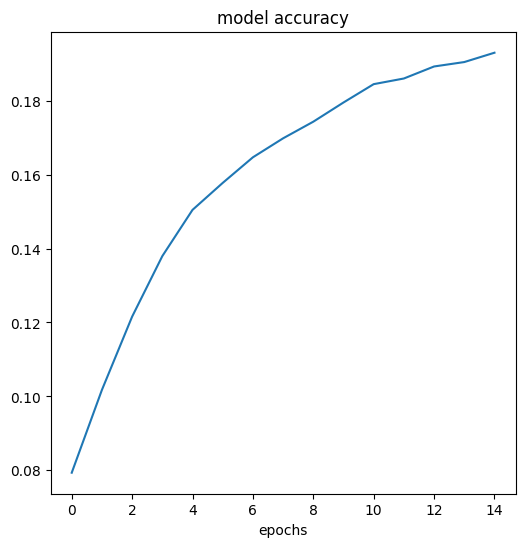

In [ ]:
fig=plt.figure(figsize=(6,6))
plt.plot(history.history['accuracy'])
plt.title("model accuracy")
plt.xlabel("epochs")
plt.show()

In [ ]:
model.save('trained_model.h5')

In [ ]:
with open('trained_model.hs', 'wb') as f:
    pickle.dump(model,f)

In [ ]:
seed_text = "he who"

In [ ]:
# Open the file in binary mode
with open('trained_model.hs', 'rb') as file:
    # Load the object from the pickle file
    model = pickle.load(file)

In [ ]:
next_words=8
for i in range(next_words):
    token_list=tokenizer.texts_to_sequences([seed_text])[0]
    token_list=pad_sequences([token_list],maxlen=13,padding='pre')
    predict=model.predict(token_list)
    classes_x=np.argmax(predict,axis=1)[0]
    output_word=""
    for word , index in tokenizer.word_index.items():
        if index==classes_x:
            output_word=word
            break
    seed_text+=" "+output_word


1/1 [==============================] - 0s 20ms/step


In [ ]:
print(seed_text)

he who in the water gurgle bears for thee round
